# Phase Sensitive Detection

Consider the measurement of a small DC signal voltage $V_s$ using the following circuit:

<img src='https://raw.githubusercontent.com/PyCav/Images/master/psd/initial_circuit_diagram.png'>

Ref introduces sine wave at 1st modulator and a square wave at the 2nd modulator. There is a phase difference, $\phi$ between the signals sent to 1 & 2.

- At 1 the signal is now "carried" at a high frequency, $\omega_r$, and also multiplied by the gain, $G$
- The reference signal at 2 is used to "de-modulate" the signal
- The output at 3 is then time averaged:

$
\begin{align}
    \langle V_{out} \rangle & = \frac{G \omega_r}{2 \pi}\left[ \int^{\pi / \omega_r}_{0} V_s \sin( \omega_r t + \phi) \ dt + \int^{2\pi / \omega_r}_{\pi / \omega_r} - V_s \sin(\omega_r t + \phi) \ dt \right] \\
    & = \frac{2}{\pi}V_s G \cos{\phi}
\end{align}
$

Below a plot shows the two modulating signals and the resultant signal at 3

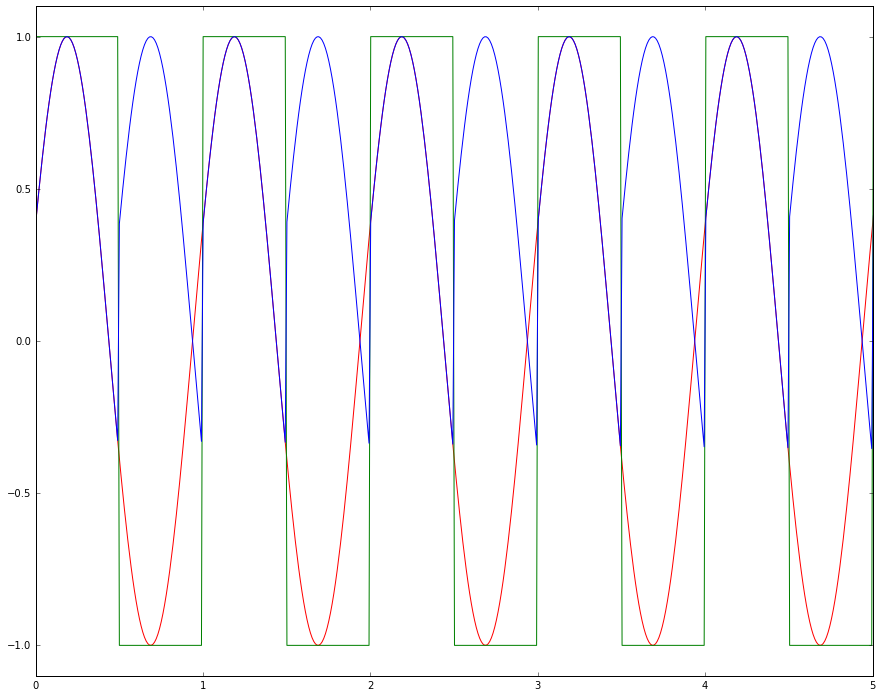

In [1]:
from scipy.signal import square
from scipy.fftpack import fft,fftshift
from scipy.integrate import simps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian(x,mu,sg):
    return np.exp(-(x-mu)**2/(2*sg**2))

V_s     = 1.
V_n_sg  = 10.
V_n_of  = 2.
G       = 100.
omega_r = 2*np.pi
phi     = np.pi/8.
N_osc   = 10

t      = np.linspace(0.,N_osc*2*np.pi/omega_r,1000)
signal = V_s*np.ones_like(t)
noise  = np.random.normal(loc = V_n_of, scale = V_n_sg,size = len(t))

first_modulation = np.sin(omega_r*t+phi)
secnd_modulation = square(omega_r*t,0.5)

resultant_signal = (first_modulation*signal+noise)*G*secnd_modulation

fig1 = plt.figure(figsize = (15,12))
ax1  = fig1.add_subplot(111)
ax1.plot(t,first_modulation,'r')
ax1.plot(t,secnd_modulation,'g')
ax1.plot(t,first_modulation*secnd_modulation,'b')
ax1.set_ylim(-1.1,1.1)
ax1.set_xlim(0.,5.*(2*np.pi)/omega_r);

## Noise inserted after first modulation

Noise entering the lock-in after the first modulation will be modulated by the second modulator. Hence the noise will be randomized by the reference signal at the 2nd modulator and will average towards zero. This even works for offsets at zero frequency

<img src='https://raw.githubusercontent.com/PyCav/Images/master/psd/add_noise_after_first_modulation.png'>

Below is the output signal when noise is inserted after the first modulator. The noise consists of random samples from a normal distribution with mean value $V_{n,of}$ and std. dev. $V_{n,sg}$ (which can be found in the first code cell).

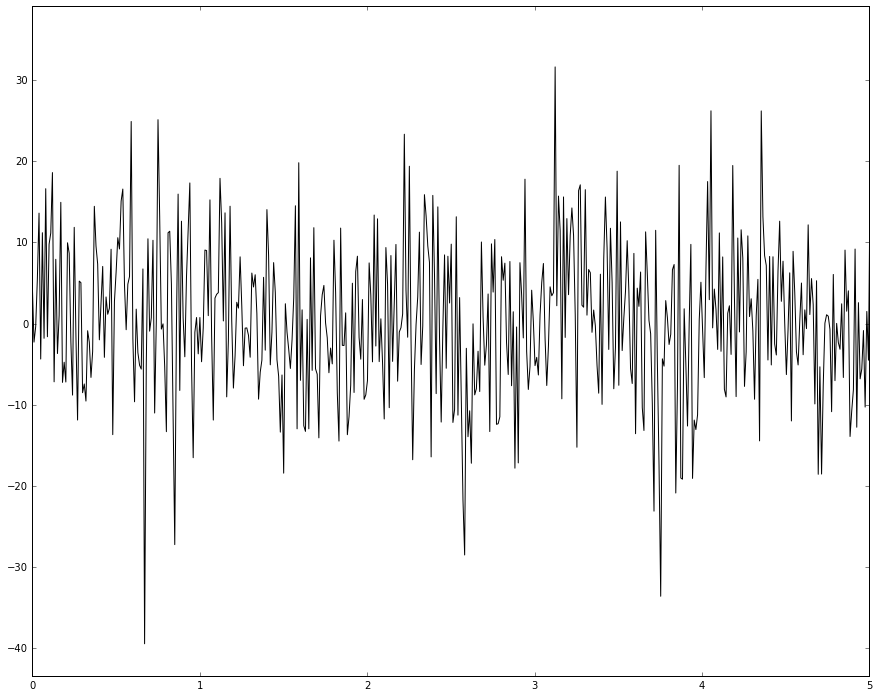

In [2]:
fig2 = plt.figure(figsize = (15,12))
ax2  = fig2.add_subplot(111)
ax2.plot(t,resultant_signal/G,'k')
ax2.set_ylim(1.1*resultant_signal.min()/G,1.1*resultant_signal.max()/G)
ax2.set_xlim(0.,5.*(2*np.pi)/omega_r);

### Power spectrum

By taking the Fourier transform, the power spectrum of the output signal can be observed. Below is a plot showing the power spectrum on a log-lin plot.

The red and green lines show the power spectrums for the sine and square wave modulating waves respectively. The black line shows the Fourier transform of the modulated input signal without noise and the blue line shows the same but only for the noise (without the input signal). It should be noted that since the modulating signals and multiplied in the time-domain, they are convolved in the frequency-domain to form the black line.

The plots above and below show the noise largely obscures the signal.

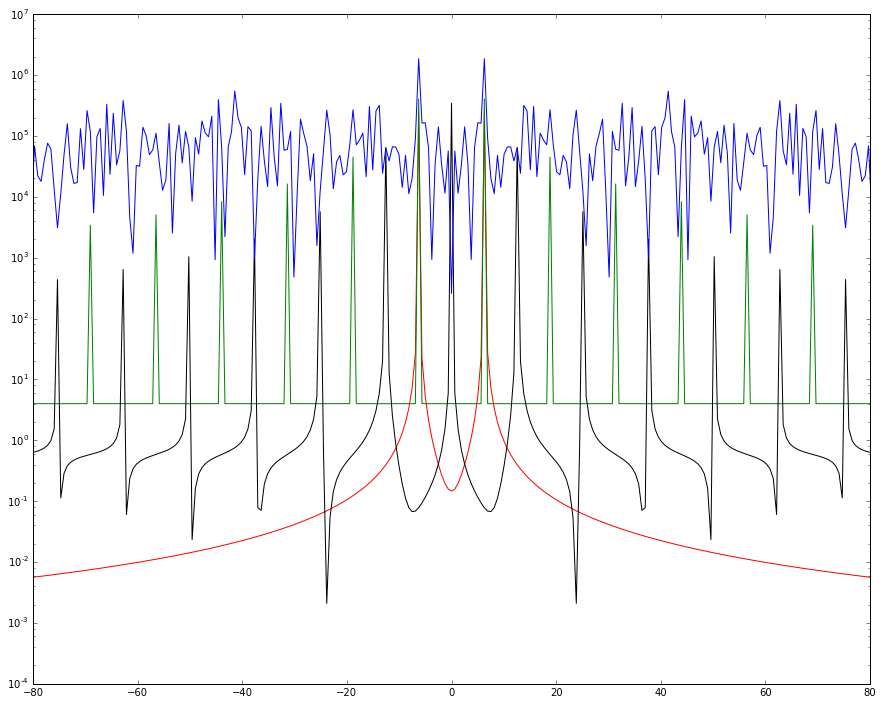

In [3]:
d_omega = 2*np.pi/(len(t)*(t[1]-t[0]))
omega_0 = np.pi/(t[1]-t[0])

omega   = d_omega*np.arange(len(t))-omega_0

fig3 = plt.figure(figsize = (15,12))
ax3  = fig3.add_subplot(111)
ax3.semilogy(omega,fftshift(abs(fft(first_modulation))**2),'r')
ax3.semilogy(omega,fftshift(abs(fft(secnd_modulation))**2),'g')
ax3.semilogy(omega,fftshift(abs(fft((first_modulation*signal)*secnd_modulation))**2),'k')
ax3.semilogy(omega,fftshift(abs(fft(noise*secnd_modulation))**2),'b')
ax3.set_xlim(-80,80);

### Integrating for long times

By integrating over N cycles, the signal voltage can be extracted from the running mean of many integrations.

The plot below shows the measured signal voltage as a function of the number integration cycles in blue and the real input voltage, $V_s$, as a black dotted line.

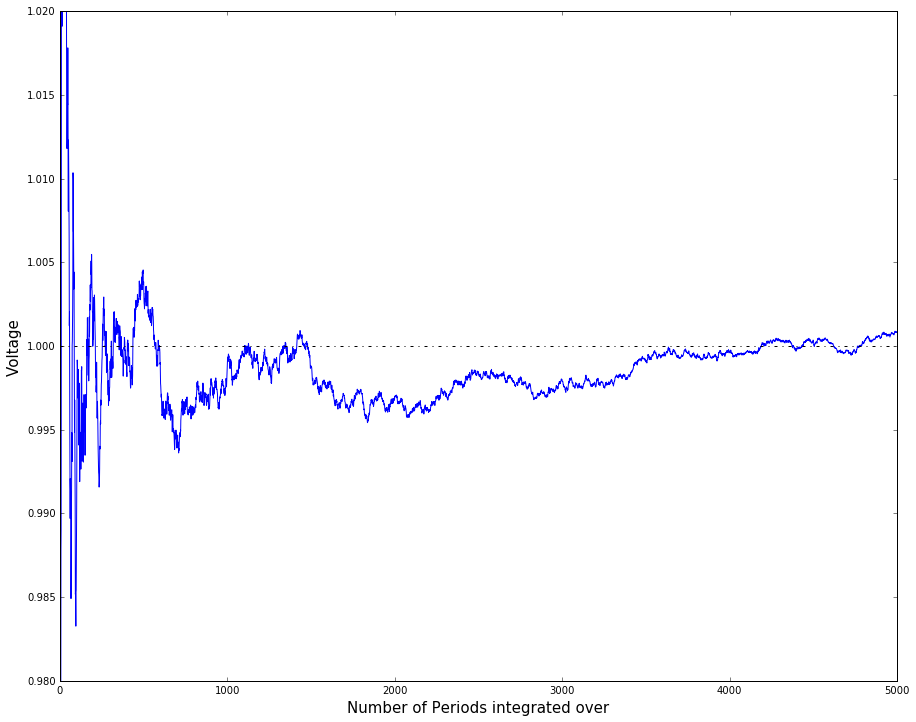

In [4]:
def running_mean(x,N):
    avg = []
    for n in N:
        cumsum = np.cumsum(np.insert(x, 0, 0))
        avg.append((cumsum[n:] - cumsum[:-n])[0] / n )
    return np.asarray(avg)

N_osc_i   = 5000
N_pts_i   = 10000

t_i      = np.linspace(0.,2*np.pi/omega_r,N_pts_i+1,endpoint = False)
dt       = t_i[1]-t_i[0]
signal_i = V_s*np.ones_like(t_i)

first_modulation_i = np.sin(omega_r*t_i+phi)
secnd_modulation_i = square(omega_r*t_i,0.5)

I = []
for i in range(N_osc_i):
    noise_i  = np.random.normal(loc = V_n_of, scale = V_n_sg,size = len(t_i))
    resultant_signal_i = (first_modulation_i*signal_i+noise_i)*G*secnd_modulation_i
    
    I_i   = simps(resultant_signal_i,dx = dt)
    I.append(I_i)

I = np.asarray(I)
N = np.arange(N_osc_i)+1
V = np.pi*running_mean(I,N)/(2*G*np.cos(phi))
fig4 = plt.figure(figsize = (15,12))
ax4  = fig4.add_subplot(111)
ax4.plot(N,V,'b')
ax4.axhline(V_s,c='k',ls='-.')
ax4.set_ylabel('Voltage', fontsize = 15)
ax4.set_xlabel('Number of Periods integrated over', fontsize = 15)
ax4.set_ylim((0.98,1.02));

## Isolating single noise Fourier component

If we explore the behaviour of a sinusoidally varying noise component, we can show that a suitably long time average will eliminate its contribution. Thus noise containing many Fourier components will also tend to zero given a long enough time (as shown in the example above).

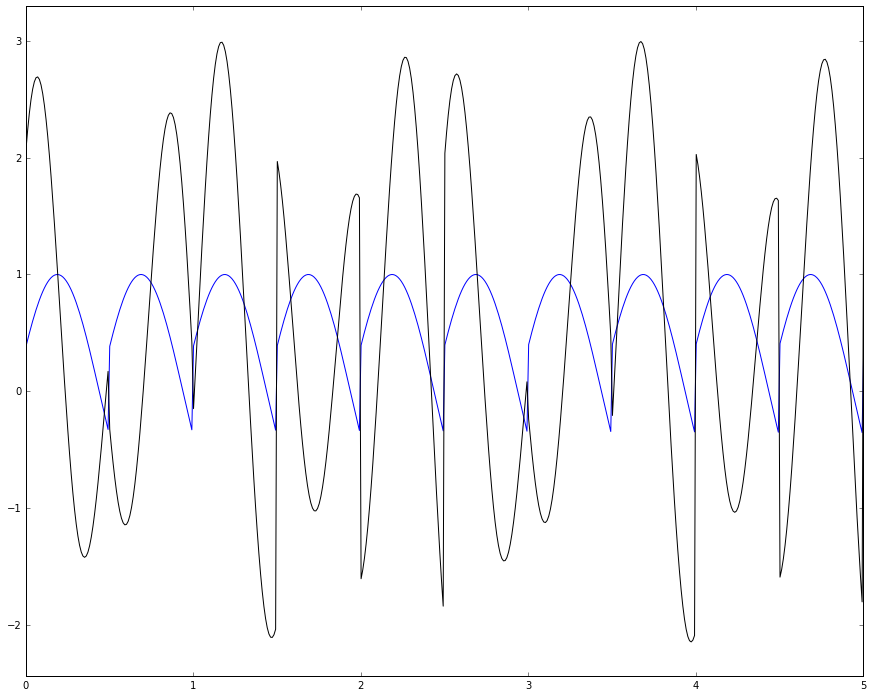

In [5]:
Delta_omega = 5.0
theta       = 1.0
V_n         = 2.0

noise_sin   = V_n*np.sin((Delta_omega+omega_r)*t+theta)

resultant_signal_sin = (first_modulation*signal+noise_sin)*G*secnd_modulation

fig5 = plt.figure(figsize = (15,12))
ax5  = fig5.add_subplot(111)
ax5.plot(t,first_modulation*secnd_modulation,'b')
ax5.plot(t,resultant_signal_sin/G,'k')
ax5.set_ylim(1.1*resultant_signal_sin.min()/G,1.1*resultant_signal_sin.max()/G)
ax5.set_xlim(0.,5.*(2*np.pi)/omega_r);

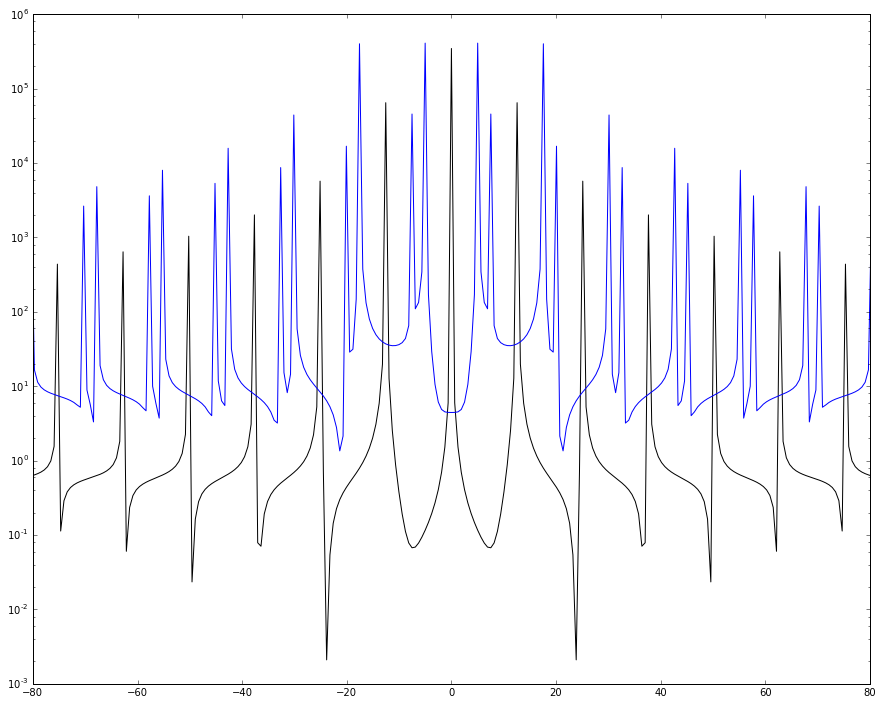

In [6]:
fig6 = plt.figure(figsize = (15,12))
ax6  = fig6.add_subplot(111)
ax6.semilogy(omega,fftshift(abs(fft((first_modulation*signal)*secnd_modulation))**2),'k')
ax6.semilogy(omega,fftshift(abs(fft(noise_sin*secnd_modulation))**2),'b')
ax6.set_xlim(-80,80);

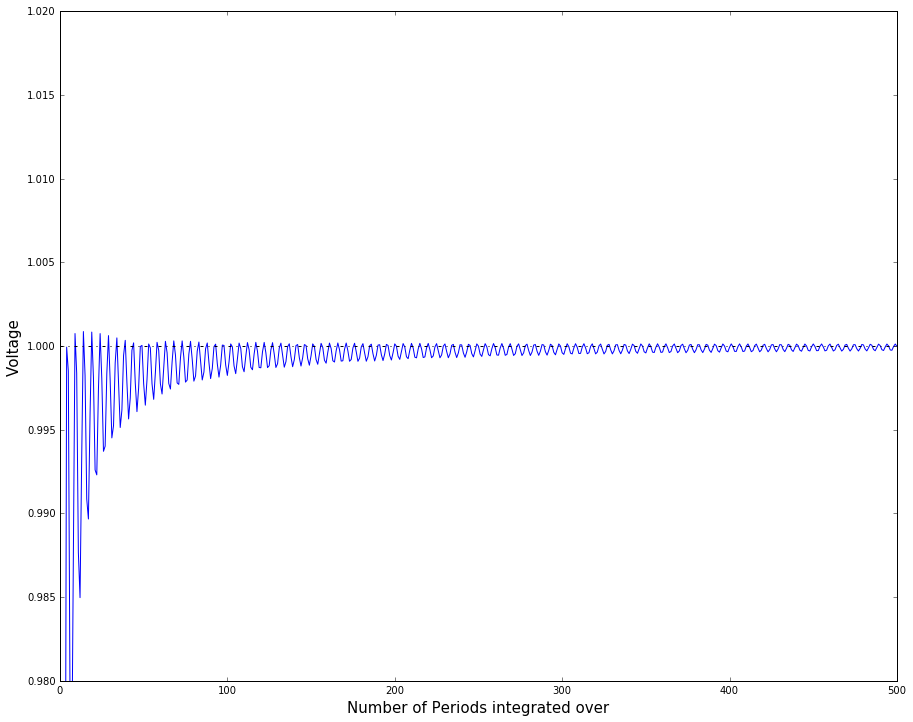

In [7]:
N_osc_sin = 500

T = 2*np.pi/omega_r

I_sin = []
for i in range(N_osc_sin):
    noise_sin_i = V_n*np.sin((Delta_omega+omega_r)*(t_i+T*i)+theta)
    resultant_signal_i = (first_modulation_i*signal_i+noise_sin_i)*G*secnd_modulation_i
    I_i   = simps(resultant_signal_i,dx = dt)
    I_sin.append(I_i)

I_sin = np.asarray(I_sin)
N_sin = np.arange(N_osc_sin)+1
V_sin = np.pi*running_mean(I_sin,N_sin)/(2*G*np.cos(phi))
fig7 = plt.figure(figsize = (15,12))
ax7  = fig7.add_subplot(111)
ax7.plot(N_sin,V_sin,'b')
ax7.axhline(V_s,c='k',ls='-.')
ax7.set_ylabel('Voltage', fontsize = 15)
ax7.set_xlabel('Number of Periods integrated over', fontsize = 15)
ax7.set_ylim(0.98,1.02);

## Incoherent phase of noise at $\omega_r$

Even noise at $\omega_r$ will average out if it consists of components with different phases (i.e. it’s incoherent), since $\langle \Sigma \cos \theta \rangle = 0$

Here we average $N_{phase}$ incoherent noise contributions at $\omega_r$ to show that these will tend to zero and not effect the measurement.

Below shows a plot of the signal output in blue, the noisy output in red and the resultant output in black.

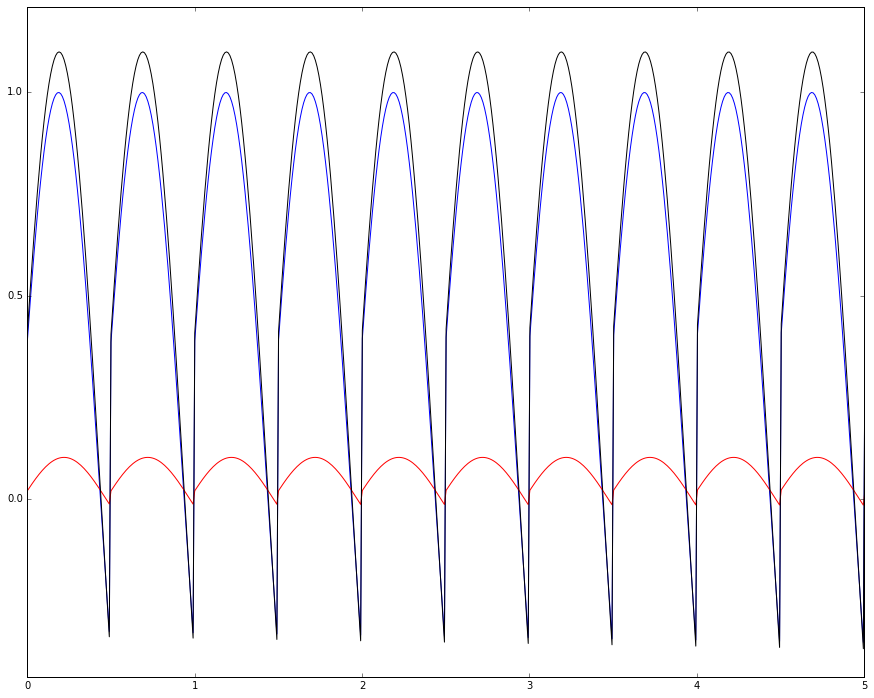

In [8]:
N_phase     = 500
rand_theta  = 2*np.pi*np.random.random(N_phase)-np.pi
noise_theta = sum([V_n*np.sin(omega_r*t+rand_theta[j]) for j in range(N_phase)])/N_phase

resultant_signal_theta = (first_modulation*signal+noise_theta)*G*secnd_modulation

fig8 = plt.figure(figsize = (15,12))
ax8  = fig8.add_subplot(111)
ax8.plot(t,first_modulation*secnd_modulation,'b')
ax8.plot(t,noise_theta*secnd_modulation,'r')
ax8.plot(t,resultant_signal_theta/G,'k')
ax8.set_ylim(1.1*resultant_signal_theta.min()/G,1.1*resultant_signal_theta.max()/G)
ax8.set_xlim(0.,5.*(2*np.pi)/omega_r);

To illustrate the effect of "decreasing coherence" of the input noise, the plot below shows the measured voltage as a function of the number of phases, $\theta$, used in the noisy signal at $\omega_r$

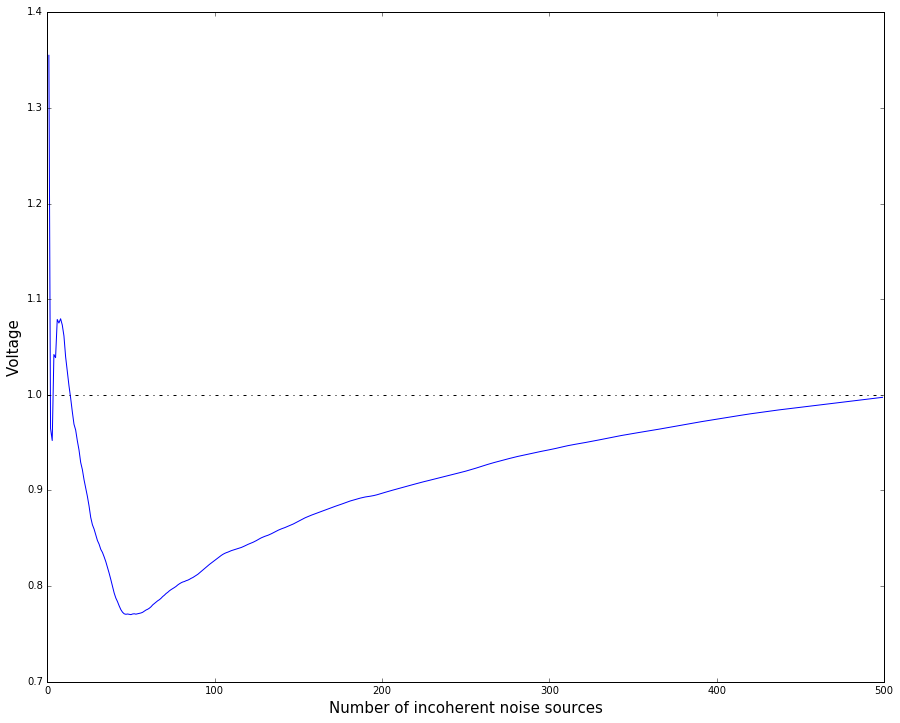

In [9]:
I_theta = []
for i in range(1,N_phase):
    noise_theta = sum([V_n*np.sin(omega_r*t_i+rand_theta[j]) for j in range(i)])/(i+1)
    resultant_signal_i = (first_modulation_i*signal_i+noise_theta)*G*secnd_modulation_i
    I_i   = simps(resultant_signal_i,dx = dt)
    I_theta.append(I_i)

I_theta = np.asarray(I_theta)
N_theta = np.arange(1,N_phase)
V_theta = np.pi*running_mean(I_theta,N_theta)/(2*G*np.cos(phi))

fig9 = plt.figure(figsize = (15,12))
ax9  = fig9.add_subplot(111)
ax9.plot(N_theta,V_theta,'b')
ax9.axhline(V_s,c='k',ls='-.')
ax9.set_ylabel('Voltage', fontsize = 15)
ax9.set_xlabel('Number of incoherent noise sources', fontsize = 15);